# 10wk-2: (추천시스템) – optimizer 사용 고급, MF-based 추천시스템

최규빈  
2025-05-12

<a href="https://colab.research.google.com/github/guebin/DL2025/blob/main/posts/10wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [1]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-xl7f2bcPTKMVCe3kHM380M&si=5SO7pni3fXX4kK-4 >}}

# 2. Imports

In [3]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

# 3. 예비학습

## A. optimizr 사용 고급

`# 회귀분석` – 안알려줬던 기술..

주어진 자료가 아래와 같다고 하자.

In [296]:
torch.manual_seed(43052)
x,_ = torch.randn(100).sort()
x = x.reshape(-1,1)
ones= torch.ones(100).reshape(-1,1)
X = torch.concat([ones,x],axis=-1)
ϵ = torch.randn(100).reshape(-1,1)*0.5
y = 2.5+ 4*x + ϵ

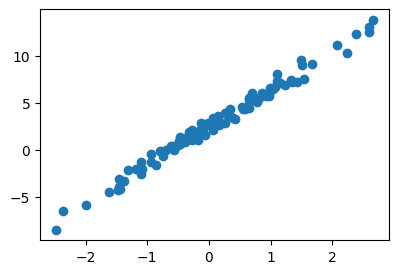

In [297]:
plt.plot(x,y,'o')

In [300]:
w = torch.tensor(10.0,requires_grad=True)
b = torch.tensor(-5.0,requires_grad=True)

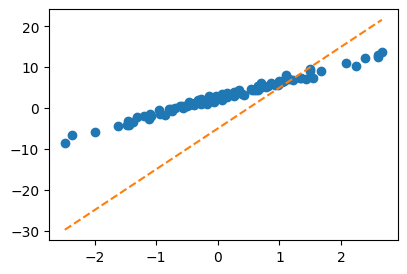

In [301]:
plt.plot(x,y,'o')
plt.plot(x,(x*w + b).data,'--')

`torch.optim.SGD`를 이용하여 What을 update하라. 학습률은 0.1로 설정하고
30회 update하라.

In [302]:
# net  
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.SGD([w,b],lr=0.1)
#--#
for epoc in range(30):
    # step1 
    yhat = x*w+b 
    # step2
    loss = loss_fn(yhat,y)
    # step3 
    loss.backward()
    # step4 
    optimizr.step()
    optimizr.zero_grad()

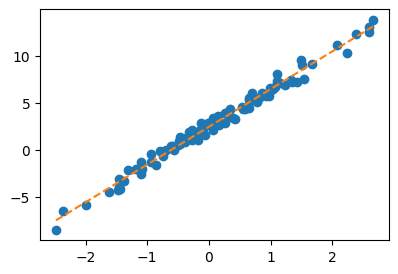

In [303]:
plt.plot(x,y,'o')
plt.plot(x,(x*w + b).data,'--')

`#`

`# 2025-중간고사 3번`

In [276]:
torch.manual_seed(43052)
dist = torch.distributions.Exponential(1/2)
x = dist.sample((10000,1))

주어진 자료 $x_i$에 대하여 함수 $l(\lambda)$를 최대화하는 $\lambda$를
경사하강법 기반의 알고리즘을 이용하여 추정하라. 단 이때 $\lambda$의 초기
추정값은 1로 설정하라.

$$
l(\lambda) =\frac{1}{n} \sum_{i=1}^{n}\log f(x_i), \quad f(x_i) = \frac{1}{\lambda} e^{-\frac{x_i}{\lambda}}, \quad x_i \geq 0
$$

**hint**

-   $l(\lambda)$를 최대화하는 $\lambda$는 $-l(\lambda)$를 최소화합니다.
-   이론적으로는 $l(\lambda)$를 최대화하는 $\lambda$는 `x.mean()`입니다.
    즉 제대로 $\lambda$를 추정한다면 `x.mean()`이 나오도록 되어있습니다.
-   저는 경사하강법을 이용했고 학습률은 0.05로 설정했습니다. 1000회
    update하니까 잘 수렴했습니다.

`(풀이1)`

In [289]:
lamb = torch.tensor([[1.0]],requires_grad=True)
for i in range(1000):
    fx = torch.exp(-x/lamb)/lamb
    l = - torch.log(fx).mean()
    l.backward()
    lamb.data = lamb.data - 0.05 * lamb.grad
    lamb.grad = None 

In [290]:
lamb

`(풀이2)`

In [293]:
lamb = torch.tensor([[1.0]],requires_grad=True)
optimizr = torch.optim.SGD([lamb],lr=0.1)
for i in range(1000):
    fx = torch.exp(-x/lamb)/lamb
    l = - torch.log(fx).mean()
    l.backward()
    optimizr.step()
    optimizr.zero_grad()

In [294]:
lamb

`#`

## B. 모델링 전략

`# 2025-중간고사 4번` – 자유 낙하 운동이란 어떤 물체가 일정한 높이에서
떨어져 지면에 도달하기 까지 걸리는 시간을 다루는 물리학 개념이다. 다음은
물리학의 자유 낙하 운동에서 착안하여 생성한 데이터이다.

In [313]:
torch.manual_seed(43052)
h = torch.rand(100)*100
h,_ = h.sort()
h = h.reshape(100,1)
t = torch.sqrt(2*h/9.8) + torch.randn([100,1])*0.1

여기에서 $h$는 낙하전의 높이(단위: m), $t$는 해당높이에서 물치가 지면에
도달하기 까지 걸리는 시간(단위:초)을 의미한다. 예를 들어 아래의 자료는
$h=99.3920, t=4.4583$를 의미하는데

In [315]:
h[-1], t[-1]

이것은 높이 $99.3920$m에서 낙하한 물체가 약 $4.4583$초만에 지면에
도달했음을 의미한다. 아래의 그림은 $x$축에 $h$, $y$축에 $t$를 두고 해당
데이터를 산점도로 시각화 한 것이다.

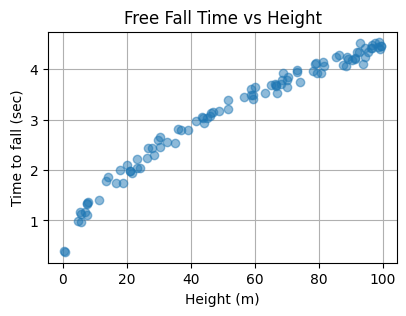

In [316]:
plt.plot(h,t,'o',alpha=0.5)
plt.xlabel('Height (m)')
plt.ylabel('Time to fall (sec)')
plt.title('Free Fall Time vs Height')
plt.grid(True)
plt.show()

그래프를 보면 높이가 높을 수록 낙하시간도 길어지는 경향이 관찰된다. 다만
동일한 높이라 하더라도 낙하시간이 조금씩 차이나는 경우가 있는데, 이는
사람이 시간측정을 수동으로 하며 발생하는 실험오차 때문이다. 이러한
오차에도 불구하고 $h$와 $t$사이에는 일정한 규칙이 존재하는듯 하다.
물리학과 교수님께 자문을 요청한 결과 자유낙하에 걸리는 시간은
$\sqrt{h}$에 비례함을 알 수 있었고 이를 근거로 아래와 같은 모형을
설계하였다.

$$t_i = \beta_0 + \beta_1 \sqrt{h_i}+\epsilon_i, \quad \epsilon_i \sim {\cal N}(0,\sigma^2)$$

위의 모형을 활용하여 높이 $h$로부터 낙하시간 $t$를 예측하는 신경망
모델을 설계하고 학습하라. 학습한 신경망 모델을 활용하여 높이 40m,60m,80m
에서 물체를 자유낙하 시켰을때 지면에 도달하기까지 걸리는 시간을 각각
예측하라.

**hint**

-   $y_i = t_i$ 로 생각하시고 $x_i= \sqrt{h}_i$로 생각하시면 그냥
    회귀모형이죠?
-   답은 $2.8571$초, $3.4493$초, $4.0406$초 근처로 나오면 됩니다.
-   제시된 모형($t_i = \beta_0 + \beta_1 \sqrt{h_i}+\epsilon_i$)을
    무시하고 04wk-2와 같은 방식으로 신경망을 설계하고 푸셔도 만점으로
    인정합니다.

`(풀이1)`

In [324]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,32),
    torch.nn.ReLU(),
    torch.nn.Linear(32,1)
)
optimizr = torch.optim.Adam(net.parameters())
loss_fn = torch.nn.MSELoss()
#---#
for epoc in range(1000):
    ##1
    that = net(h)
    ##2
    loss = loss_fn(that,t)
    ##3
    loss.backward()
    ##4
    optimizr.step()
    optimizr.zero_grad()

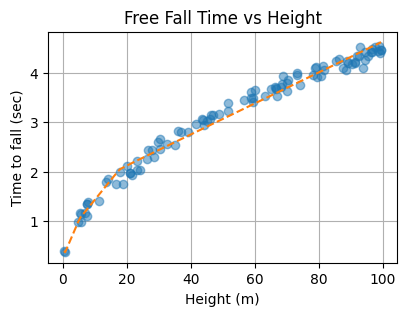

In [325]:
plt.plot(h,t,'o',alpha=0.5)
plt.xlabel('Height (m)')
plt.ylabel('Time to fall (sec)')
plt.title('Free Fall Time vs Height')
plt.grid(True)
plt.plot(h,that.data, '--')
plt.show()

In [328]:
hh = torch.tensor([40,60,80]).float().reshape(3,1)
net(hh)

`(풀이2)`

In [330]:
x = torch.sqrt(h)
y = t 
net = torch.nn.Sequential(
    torch.nn.Linear(1,1)
)
optimizr = torch.optim.Adam(net.parameters())
loss_fn = torch.nn.MSELoss()
#---#
for epoc in range(1000):
    ##1
    yhat = net(x)
    ##2
    loss = loss_fn(yhat,y)
    ##3
    loss.backward()
    ##4
    optimizr.step()
    optimizr.zero_grad()

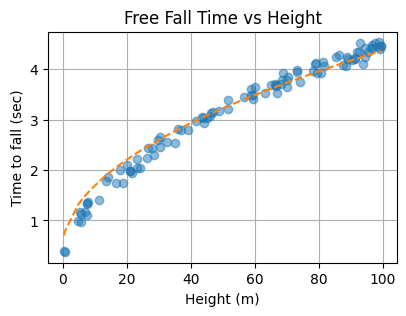

In [333]:
plt.plot(h,t,'o',alpha=0.5)
plt.xlabel('Height (m)')
plt.ylabel('Time to fall (sec)')
plt.title('Free Fall Time vs Height')
plt.grid(True)
plt.plot(x**2,yhat.data, '--')
plt.show()

In [334]:
xx = torch.sqrt(torch.tensor([40,60,80])).float().reshape(3,1)
net(xx)

# 4. MF-based 추천시스템

ref: <https://namu.wiki/w/나는%20SOLO>

## A. Data: 나는 SOLO

`-` Data

In [15]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2025/main/posts/iamsolo.csv',index_col=0)
df_view

`-` 데이터를 이해할 때 필요한 가정들 – 제가 마음대로 설정했어요..

-   궁합이 잘맞으면 5점, 잘 안맞으면 0점 이다.
-   MBTI 성향에 따라서 궁함의 정도가 다르다. 특히 I/E의 성향일치가
    중요하다.
-   하니는 모든 사람들과 대체로 궁합이 잘 맞는다.

## B. 아이디어

`-` 목표: NaN을 추정

`-` 수동추론: 그럴듯한 숫자를 추정해보자.

-   옥순(IN),영식(IN)의 궁합은? $\to$ 잘 맞을듯
-   서연(ES),규빈(ES)의 궁합은? $\to$ 잘 맞을듯
-   영자(IN),다호(ES)의 궁합은? $\to$ 잘 안맞을듯
-   하니(I),영호(IS)의 궁합은? $\to$엄청 잘 맞을듯

`-` 좀 더 체계적인 추론 전략

In [27]:
sig = torch.nn.Sigmoid()

**(1)** 옥순(IN)과 영식(IN)의 궁합 $\approx$
옥순의I/E성향$\times$영식의I/E성향 $+$
옥순의N/S성향$\times$영식의N/S성향

In [152]:
옥순성향 = torch.tensor([1.9, 1.9]).reshape(1,2)
영식성향 = torch.tensor([1.9,1.9]).reshape(1,2)
sig(((옥순성향*영식성향).sum()))*5
sig((옥순성향@영식성향.T))*5

**(2)** 서연(ES)과 규빈(ES)의 궁합 $\approx$
서연의I/E성향$\times$규빈의I/E성향 $+$
서연의N/S성향$\times$규빈의N/S성향

In [153]:
서연성향 = torch.tensor([-1.9, -1.9]).reshape(1,2)
규빈성향 = torch.tensor([-1.9,-1.9]).reshape(1,2)
sig(((서연성향*규빈성향).sum()))*5
sig((서연성향@규빈성향.T))*5

**(3)** 영자(IN)와 다호(ES)의 궁합 $\approx$
영자I/E성향$\times$다호I/E성향 $+$ 영자N/S성향$\times$다호의N/S성향

In [340]:
영자성향 = torch.tensor([1.9,1.9]).reshape(1,2)
다호성향 = torch.tensor([-1.9,-1.9]).reshape(1,2)
sig(((영자성향*다호성향).sum()))*5
sig((영자성향@다호성향.T))*5

**(4)** 하니(I)와 영호(IS)의 궁합 $\approx$
하니I/E성향$\times$영호I/E성향 $+$ 하니N/S성향$\times$영호의N/S성향 $+$
**하니의매력**

In [155]:
하니성향 = torch.tensor([2.0, 0]).reshape(1,2)
하니매력 = torch.tensor(5)
영호성향 = torch.tensor([2.0,-2.0]).reshape(1,2)
영호매력 = torch.tensor(0)
sig(((하니성향*영호성향).sum() + 하니매력))*5
sig((하니성향@영호성향.T + 하니매력))*5

> 전체적으로 그럴싸함

`-` 전체 사용자의 설정값

In [156]:
옥순성향 = torch.tensor([1.8,1])
영자성향 = torch.tensor([1.8,1])
정숙성향 = torch.tensor([1.8,-1])
영숙성향 = torch.tensor([1.8,-1])
순자성향 = torch.tensor([-1.8,1])
현숙성향 = torch.tensor([-1.8,1])
서연성향 = torch.tensor([-1.8,-1])
보람성향 = torch.tensor([-1.8,-1])
하니성향 = torch.tensor([1.8,0])
W = torch.stack([옥순성향,영자성향,정숙성향,영숙성향,순자성향,현숙성향,서연성향,보람성향,하니성향])
b1 = torch.tensor([0,0,0,0,0,0,0,0,5]).reshape(-1,1) 
W,b1

In [157]:
영식성향 = torch.tensor([1.8,1])
영철성향 = torch.tensor([1.8,1])
영호성향 = torch.tensor([1.8,-1])
광수성향 = torch.tensor([1.8,-1])
상철성향 = torch.tensor([-1.8,1])
영수성향 = torch.tensor([-1.8,1])
규빈성향 = torch.tensor([-1.8,-1])
다호성향 = torch.tensor([-1.8,-1])
M = torch.stack([영식성향,영철성향,영호성향,광수성향,상철성향,영수성향,규빈성향,다호성향]) # 각 column은 남성출연자의 성향을 의미함
b2 = torch.zeros(8).reshape(-1,1)
M,b2

`-` 아래의 행렬곱 관찰

In [158]:
sig(W @ M.T + (b1 + b2.T))*5

In [159]:
df_view

> 안 비슷하긴한데 느낌있음

`-` 모델링

$${\tt df\_view} \approx sig\left({\bf W}@{\bf M}^\top + bias \right) \times 5$$

`-` 자료를 아래와 같이 정리한다면?

In [229]:
df_train = df_view.stack().reset_index().set_axis(["여성출연자","남성출연자","궁합점수"],axis=1)
df_train

In [231]:
X1 = torch.nn.functional.one_hot(torch.tensor(df_train.여성출연자.map({name:i for i,name in enumerate(set(df_train.여성출연자))}))).float()
X2 = torch.nn.functional.one_hot(torch.tensor(df_train.남성출연자.map({name:i for i,name in enumerate(set(df_train.남성출연자))}))).float()
y = torch.tensor(df_train.궁합점수).float().reshape(-1,1)

In [232]:
X1.shape, X2.shape, y.shape

In [233]:
l1 = torch.nn.Linear(9,2,bias=False)
b1 = torch.nn.Linear(9,1, bias=False)
l2 = torch.nn.Linear(8,2,bias=False)
b2 = torch.nn.Linear(8,1,bias=False)

In [234]:
yhat = sig((l1(X1) * l2(X2)).sum(axis=1).reshape(-1,1)+b1(X1) + b2(X2))*5

## C. 학습

In [237]:
df_view = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2025/main/posts/iamsolo.csv',index_col=0)
df_train = df_view.stack().reset_index().set_axis(["여성출연자","남성출연자","궁합점수"],axis=1)
여성인덱스 = {'옥순(IN)':0, '영자(IN)':1, '정숙(IS)':2, '영숙(IS)':3, '순자(EN)':4, '현숙(EN)':5, '서연(ES)':6, '보람(ES)':7, '하니(I)':8}
남성인덱스 = {'영식(IN)':0, '영철(IN)':1, '영호(IS)':2, '광수(IS)':3, '상철(EN)':4, '영수(EN)':5, '규빈(ES)':6, '다호(ES)':7}
X1 = torch.nn.functional.one_hot(torch.tensor(df_train.여성출연자.map(여성인덱스))).float()
X2 = torch.nn.functional.one_hot(torch.tensor(df_train.남성출연자.map(남성인덱스))).float()
y = torch.tensor(df_train.궁합점수).float().reshape(-1,1)
#--#
torch.manual_seed(43052)
l1 = torch.nn.Linear(in_features=9, out_features=2, bias=False)
b1 = torch.nn.Linear(in_features=9, out_features=1, bias=False)
l2 = torch.nn.Linear(in_features=8, out_features=2, bias=False)
b2 = torch.nn.Linear(in_features=8, out_features=1, bias=False)
sig = torch.nn.Sigmoid()
loss_fn = torch.nn.MSELoss()
params = list(l1.parameters())+list(b1.parameters())+list(l2.parameters())+list(b2.parameters())
optimizr = torch.optim.Adam(params, lr=0.1) 
#--#
for epoc in range(100):
    ## step1 
    W_features = l1(X1)
    W_bias = b1(X1)
    M_features = l2(X2) 
    M_bias = b2(X2)
    yhat = sig((W_features * M_features).sum(axis=1).reshape(-1,1) + W_bias + M_bias) * 5 
    ## step2 
    loss = loss_fn(yhat,y)
    ## step3 
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

In [238]:
torch.concat([yhat,y],axis=1)[::4] # 꽤 잘맞음

## D. 예측

In [239]:
df_view

In [242]:
df_train[:5]

적합된 네트워크를 바탕으로 아래의 값에 대한 예측을 수행하라.

In [250]:
df_test = pd.DataFrame({'여성출연자':['옥순(IN)','하니(I)'],'남성출연자':['영식(IN)','영호(IS)']})
df_test

In [258]:
XX1 = torch.nn.functional.one_hot(torch.tensor(df_test.여성출연자.map(여성인덱스)),num_classes=9).float()
XX2 = torch.nn.functional.one_hot(torch.tensor(df_test.남성출연자.map(남성인덱스)),num_classes=8).float()

In [275]:
sig((l1(XX1) * l2(XX2)).sum(axis=1).reshape(-1,1) + b1(XX1) + b2(XX2))*5